    Architecture      RMSE        R²        VAF       MAE  \
0              5  3.350988  0.670038  67.354498  2.265328   
1             10  1.857061  0.898662  89.905492  1.097484   
2             15  1.764331  0.908530  91.006386  0.824526   
3             20  0.909666  0.975685  97.568495  0.413898   
4             25  0.594540  0.989613  98.966611  0.246092   
5              5  2.672101  0.790191  79.452406  1.560220   
6             10  1.757669  0.909220  90.988391  0.892685   
7             15  0.947802  0.973603  97.360355  0.595232   
8             20  1.195311  0.958016  95.817553  0.537597   
9             25  0.719092  0.984805  98.490597  0.316418   
10             5  3.432673  0.653756  66.063684  2.147650   
11            10  1.705453  0.914533  91.453422  0.900321   
12            15  1.430177  0.939897  93.989705  0.628792   
13            20  1.300939  0.950268  95.029020  0.597103   
14            25  1.020039  0.969426  96.949557  0.367858   
15             5  2.0240

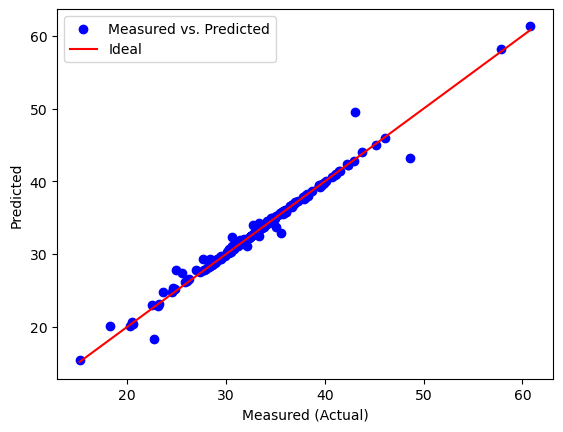

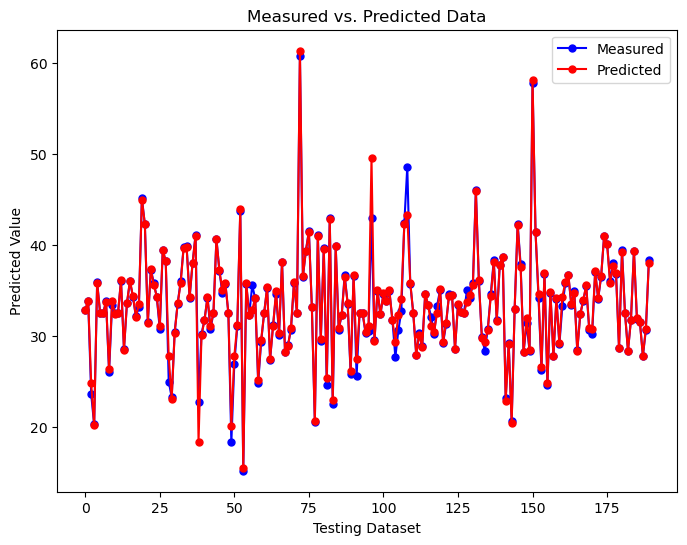

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

# Radial Basis Function Neural Network (RBFNN) class
class RBFNN:
    def __init__(self, num_centers, num_features):
        self.num_centers = num_centers
        self.num_features = num_features
        self.centers = None
        self.widths = None
        self.weights = None

    def _gaussian_kernel(self, x, center, width):
        return np.exp(-np.sum((x - center) ** 2) / (2 * width ** 2))

    def _design_matrix(self, X):
        design_matrix = np.zeros((X.shape[0], self.num_centers))

        for i in range(X.shape[0]):
            for j in range(self.num_centers):
                design_matrix[i, j] = self._gaussian_kernel(X[i], self.centers[j], self.widths[j])

        return design_matrix

    def _normalize_output(self, y):
        scaler = StandardScaler()
        y_scaled = scaler.fit_transform(y)
        return y_scaled, scaler

    def _denormalize_output(self, y_scaled, scaler):
        y = scaler.inverse_transform(y_scaled)
        return y

    def fit(self, X, y):
        self.centers = X[np.random.choice(X.shape[0], self.num_centers, replace=False)]
        self.widths = np.zeros(self.num_centers)

        for i in range(self.num_centers):
            distances = np.linalg.norm(X - self.centers[i], axis=1)
            self.widths[i] = np.mean(distances)

        design_matrix = self._design_matrix(X)
        y_scaled, scaler = self._normalize_output(y)

        self.weights = np.linalg.pinv(design_matrix) @ y_scaled

        self.scaler = scaler

    def predict(self, X):
        design_matrix = self._design_matrix(X)
        y_scaled = design_matrix @ self.weights
        y = self._denormalize_output(y_scaled, self.scaler)
        return y

# Read and preprocess the dataset
dataset = shuffle(pd.read_csv("blast_dataset1.csv"))
x = dataset[['B', 'S', 'H', 'D', 'TI', 'TF', 'L', 'C', 'PF', 'RF']].values
y = dataset[['X']].values

# Normalize input features
scaler = StandardScaler()
x = scaler.fit_transform(x)

# Split the dataset into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# Set the range of the number of centers to search
num_centers_range = [5, 10, 15, 20, 25]

# Set the random seed for reproducibility
random_seed = 40
np.random.seed(random_seed)

# Initialize variables to store the best architecture and RMSE
best_num_centers = None
best_rmse = float('inf')
best_r2 = -float('inf')

# Create a list to store the results
results = []

# Perform multiple runs
num_runs = 5
rmse_values = []
r2_values = []
vaf_values = []
mae_values = []

for run in range(num_runs):
    # Shuffle the dataset for each run
    x_train, y_train = shuffle(x_train, y_train)

    # Perform grid search
    for num_centers in num_centers_range:
        # Create an instance of RBFNN
        rbfnn = RBFNN(num_centers=num_centers, num_features=x.shape[1])

        # Train the RBFNN
        rbfnn.fit(x_train, y_train)

        # Predict on the test set
        y_pred = rbfnn.predict(x_test)

        # Calculate RMSE
        rmse = np.sqrt(np.mean((y_pred - y_test) ** 2))
        rmse_values.append(rmse)

        # Calculate R²
        ssr = np.sum((y_test - y_pred) ** 2)
        sst = np.sum((y_test - np.mean(y_test)) ** 2)
        r2 = 1 - (ssr / sst)
        r2_values.append(r2)

        # Calculate VAF
        vaf = (1 - (np.var(y_test - y_pred) / np.var(y_test))) * 100
        vaf_values.append(vaf)

        # Calculate MAE
        mae = np.mean(np.abs(y_pred - y_test))
        mae_values.append(mae)

        # Retrieve the spread factors
        spread_factors = rbfnn.widths

        # Retrieve the network architecture
        num_inputs = x.shape[1]
        num_hidden_layers = 1  # Since RBFNN has a single hidden layer
        num_outputs = 1  # Since the prediction is a single output

        # Check if current architecture is the best
        if rmse < best_rmse:
            best_rmse = rmse
            best_num_centers = num_centers
            best_spread_factors = spread_factors
            best_net_structure = (num_inputs, num_hidden_layers, num_outputs)

        # Check if current R² is the best
        if r2 > best_r2:
            best_r2 = r2

        # Append the results to the list
        results.append([num_centers, rmse, r2, vaf, mae, spread_factors])

# Convert the results list to a DataFrame
results_df = pd.DataFrame(results, columns=["Architecture", "RMSE", "R²", "VAF", "MAE", "Spread Factor"])

# Display the results in a tabular format
print(results_df)

# Display the best number of centers, the corresponding best RMSE, R², spread factors, and network architecture
print("Best Number of Centers:", best_num_centers)
print("Best RMSE:", best_rmse)
print("Best R²:", best_r2)
print("Best Spread Factors:", best_spread_factors)
print("Best Network Architecture:", best_net_structure)

# Plot the correlation graph
plt.scatter(y_test, y_pred, c='b', label='Measured vs. Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], c='r', label='Ideal')
plt.xlabel('Measured (Actual)')
plt.ylabel('Predicted')
plt.legend()
plt.show()

# Add a line graph of the predicted and measured data
plt.figure(figsize=(8, 6))
plt.plot(y_test, label='Measured', marker='o', color='blue',markersize=5)
plt.plot(y_pred, label='Predicted', marker='o', color='red',markersize=5)     #x
plt.xlabel('Testing Dataset')
plt.ylabel('Predicted Value')
plt.title('Measured vs. Predicted Data')
plt.legend()


plt.show()

